# **Fraudulent Transaction Detection for Digital Money Transfer**

This notebook documents the end-to-end development of a **machine learning–driven fraud detection system** for NovaPay, a cross-border digital money transfer platform. The primary intention is to showcase how supervised classification models, combined with advanced resampling techniques and explainability tools, can effectively identify fraudulent transactions in highly imbalanced datasets (<1% fraud prevalence).

Key objectives include:
- **Supervised Classification**: Building robust models (Logistic Regression, Random Forest, XGBoost, LightGBM) to distinguish fraudulent vs. legitimate transactions.
- **Class Imbalance Handling**: Applying SMOTE, class weighting, and ensemble methods to improve recall without sacrificing precision.
- **Explainability Integration**: Using SHAP values to provide transaction-level transparency for analysts and regulators.
- **Deployment Readiness**: Packaging the solution as a FastAPI microservice with Docker for real-time scoring in production.
- **Monitoring & Maintenance**: Implementing drift detection with Evidently and establishing retraining playbooks for evolving fraud patterns.

The overarching goal is to deliver a **15% improvement in fraud detection recall** compared to rules-based baselines, while maintaining user trust, regulatory compliance, and operational efficiency. This notebook serves as both a technical blueprint and a stakeholder-facing artifact, ensuring clarity, reproducibility, and alignment with NovaPay’s mission to provide secure, affordable, and lightning-fast digital financial services.


In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#

# Importing the required Libraries!

In [ ]:
import numpy as np              # Numerical computations
import pandas as pd             # Data manipulation and analysis
import matplotlib.pyplot as plt # Data visualization
import seaborn as sns           # Advanced visualization
import sklearn                  # Machine learning tools


#

# Data injection: loading datasets into the workflow

In [ ]:
first_csv = pd.read_csv('/content/drive/MyDrive/NovaPay_Fraud_Predictive_Model/nova_pay.csv')                                       # Loading the first csv file
second_csv = pd.read_csv('/content/drive/MyDrive/NovaPay_Fraud_Predictive_Model/nova_pay_fraud_boost - nova_pay_fraud_boost.csv')   # Loading the second csv file
merged_csv = pd.concat([first_csv, second_csv], ignore_index=True)                                                                  # Merging the two cvs files together
merged_csv.to_csv('/content/drive/MyDrive/NovaPay_Fraud_Predictive_Model/nova_pay_merged.csv', index=False)                         # Saving the merged csv file
master_df = pd.read_csv('/content/drive/MyDrive/NovaPay_Fraud_Predictive_Model/nova_pay_merged.csv')                                # Loading the merged csv into master dataframe
print("✅ Two CSV files merged successfully into 'merged_file.csv'", master_df.shape)
master_df.head()

✅ Two CSV files merged successfully into 'merged_file.csv' (11400, 26)


,transaction_id,customer_id,timestamp,home_country,source_currency,dest_currency,channel,amount_src,amount_usd,fee,...,ip_risk_score,kyc_tier,account_age_days,device_trust_score,chargeback_history_count,risk_score_internal,txn_velocity_1h,txn_velocity_24h,corridor_risk,is_fraud
0,fee8542d-8ee6-4b0d-9671-c294dd08ed26,402cccc9-28de-45b3-9af7-cc5302aa1f93,2022-10-03 18:40:59.468549+00:00,US,USD,CAD,ATM,278.19,278.19,4.25,...,0.123,standard,263,0.522,0,0.223,0,0,0.0,0
1,bfdb9fc1-27fe-4a85-b043-4d813d679259,67c2c6b3-ef0a-4777-a3f1-c84a851bb6ad,2022-10-03 20:39:38.468549+00:00,CA,CAD,MXN,web,208.51,154.29,4.24,...,0.569,standard,947,0.475,0,0.268,0,1,0.0,0
2,fc855034-3ea5-4993-9afa-b511d93fe5e8,6d0d9b27-fa26-45f8-93b1-2df29d182d9c,2022-10-03 23:02:43.468549+00:00,US,USD,CNY,mobile,160.33,160.33,2.70,...,0.437,enhanced,367,0.939,0,0.176,0,0,0.0,0
3,2cf8c08e-42ec-444d-a755-34b9a2a0a4ca,7bd5200c-5d19-44f0-9afe-8b339a05366b,2022-10-04 01:08:53.468549+00:00,US,USD,EUR,mobile,59.41,59.41,2.22,...,0.594,standard,147,0.551,0,0.391,0,0,0.0,0
4,d907a74d-b426-438d-97eb-dbe911aca91c,70a93d26-8e3a-4179-900c-a4a7a74d08e5,2022-10-04 09:35:03.468549+00:00,US,USD,INR,mobile,200.96,200.96,3.61,...,0.121,enhanced,257,0.894,0,0.257,0,0,0.0,0


In [ ]:
master_df.to_csv('/content/drive/MyDrive/NovaPay_Fraud_Predictive_Model/initial_nova_pay_merged.csv', index=False)

In [ ]:
master_df.shape

(11400, 26)

In [ ]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11400 entries, 0 to 11399
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   transaction_id             11400 non-null  object 
 1   customer_id                11400 non-null  object 
 2   timestamp                  11371 non-null  object 
 3   home_country               11400 non-null  object 
 4   source_currency            11400 non-null  object 
 5   dest_currency              11400 non-null  object 
 6   channel                    11400 non-null  object 
 7   amount_src                 11400 non-null  object 
 8   amount_usd                 11095 non-null  float64
 9   fee                        11105 non-null  float64
 10  exchange_rate_src_to_dest  11400 non-null  float64
 11  device_id                  11400 non-null  object 
 12  new_device                 11400 non-null  bool   
 13  ip_address                 11095 non-null  obj

#

# 🧹 Data Cleaning Tasks:
  - Correcting the data type of the features
  - Checking and resolving duplicate records
  - Checking and resolving missing values
    - Variables with missing values:
      - 'timestamp'
      - 'amount_usd'
      - 'fee'
      - 'ip_address'
      - 'ip_country'
      - 'kyc_tier'
      - 'device_trust_score'
  - Correcting the inconsistencies in the `channel` column

#

- **Ensuring proper data types for features**

In [ ]:
# Remove unwanted commas
master_df['amount_src'] = master_df['amount_src'].str.replace(',', '')

In [ ]:
master_df['amount_src'] = master_df['amount_src'].astype(float)
master_df['is_fraud'] = master_df['is_fraud'].astype(bool)

In [ ]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11400 entries, 0 to 11399
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   transaction_id             11400 non-null  object 
 1   customer_id                11400 non-null  object 
 2   timestamp                  11371 non-null  object 
 3   home_country               11400 non-null  object 
 4   source_currency            11400 non-null  object 
 5   dest_currency              11400 non-null  object 
 6   channel                    11400 non-null  object 
 7   amount_src                 11400 non-null  float64
 8   amount_usd                 11095 non-null  float64
 9   fee                        11105 non-null  float64
 10  exchange_rate_src_to_dest  11400 non-null  float64
 11  device_id                  11400 non-null  object 
 12  new_device                 11400 non-null  bool   
 13  ip_address                 11095 non-null  obj

#

- **Addressing missing values in `ip_address`**

In [ ]:
master_df['ip_address'].isna().sum()

np.int64(305)

In [ ]:
master_df[master_df['ip_address'].isna()]

,transaction_id,customer_id,timestamp,home_country,source_currency,dest_currency,channel,amount_src,amount_usd,fee,...,ip_risk_score,kyc_tier,account_age_days,device_trust_score,chargeback_history_count,risk_score_internal,txn_velocity_1h,txn_velocity_24h,corridor_risk,is_fraud
13,1a34a095-3be4-4a69-a22e-803be566526c,7041b9c1-3719-4ca8-9a6b-811b47cea6c0,2022-10-05 07:04:39.468549+00:00,UK,GBP,EUR,mobile,322.24,NaN,NaN,...,0.245,NaN,4,NaN,0,0.407,0,0,0.05,False
49,b489474c-b729-4759-86e9-51778ddea385,402cccc9-28de-45b3-9af7-cc5302aa1f93,2022-10-08 20:45:48.468549+00:00,US,USD,INR,mobile,255.06,NaN,NaN,...,0.530,NaN,263,NaN,0,0.223,0,0,0.00,False
151,32cbd613-5c6c-4797-be15-165bc408c2ca,af8ca4c4-8703-4c55-b66c-2b76cd70040d,2022-10-20 22:08:59.468549+00:00,US,USD,MXN,mobile,502.97,NaN,NaN,...,0.310,NaN,1018,NaN,0,0.087,0,0,0.20,False
163,8b339135-7446-4689-9bd2-0509f23903f0,67c2c6b3-ef0a-4777-a3f1-c84a851bb6ad,2022-10-22 01:51:23.468549+00:00,CA,CAD,USD,web,100.87,NaN,NaN,...,0.519,NaN,947,NaN,0,0.268,7,7,0.00,False
168,c6c7f296-be97-4d18-a93e-719fcba43dce,6d0d9b27-fa26-45f8-93b1-2df29d182d9c,2022-10-22 10:08:19.468549+00:00,US,USD,MXN,mobile,265.30,NaN,NaN,...,0.655,NaN,367,NaN,0,0.176,0,0,0.20,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10054,35da0a3e-5776-4f7e-b102-5ea3d5034713,402cccc9-28de-45b3-9af7-cc5302aa1f93,2025-06-20 07:38:53.468549+00:00,US,USD,EUR,mobile,9993.94,NaN,NaN,...,0.434,NaN,263,NaN,0,0.223,0,0,0.00,False
10082,adc74103-d3b7-491e-a3c9-02aae2050d46,7bd5200c-5d19-44f0-9afe-8b339a05366b,2025-01-27 17:14:38.468549+00:00,US,USD,USD,mobile,414.29,NaN,NaN,...,0.446,NaN,147,NaN,0,0.391,0,0,0.00,True
10093,d5ce08b7-d78f-4e1b-97c0-362cc64e12ee,af8ca4c4-8703-4c55-b66c-2b76cd70040d,2024-06-28 06:10:20.468549+00:00,US,USD,PHP,mobile,125.75,NaN,NaN,...,0.451,NaN,1018,NaN,0,0.087,0,0,0.10,False
10142,356a1a21-e76c-4ad6-b712-405d3ad215e6,23d9943d-57b1-42eb-9ef2-05eed7fd1957,2024-03-04 21:11:40.468549+00:00,UK,GBP,INR,mobile,83.96,NaN,NaN,...,0.474,NaN,718,NaN,0,0.169,0,0,0.00,False


In [ ]:
master_df.dropna(subset=['ip_address'], inplace=True)    # dropping the records where ip_addresses are missing
master_df.shape

(11095, 26)

# 🧹 Note: Why `ip_address` Missing Values Are Dropped

Unlike numerical or categorical features, missing values in `ip_address` cannot be meaningfully imputed. Here’s why:

- **Uniqueness**: Each IP address is a unique identifier tied to a specific device or session. There is no logical "average" or "default" IP that can replace a missing one.  
- **Non-redundancy**: IPs do not follow a distribution that allows statistical imputation (e.g., mean, median, mode). Filling them in would introduce fabricated identifiers.  
- **Integrity**: Artificially inserting values could compromise downstream tasks such as fraud detection, geolocation, or user tracking.  
- **Traceability**: Since IP addresses are critical for audit trails, any imputation would reduce the reliability of the dataset.  

👉 Therefore, the most robust approach is to **drop records with missing `ip_address` values**, ensuring that only verifiable and complete identifiers remain in the dataset.

---

In [ ]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11095 entries, 0 to 11399
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   transaction_id             11095 non-null  object 
 1   customer_id                11095 non-null  object 
 2   timestamp                  11066 non-null  object 
 3   home_country               11095 non-null  object 
 4   source_currency            11095 non-null  object 
 5   dest_currency              11095 non-null  object 
 6   channel                    11095 non-null  object 
 7   amount_src                 11095 non-null  float64
 8   amount_usd                 11095 non-null  float64
 9   fee                        11095 non-null  float64
 10  exchange_rate_src_to_dest  11095 non-null  float64
 11  device_id                  11095 non-null  object 
 12  new_device                 11095 non-null  bool   
 13  ip_address                 11095 non-null  object 


Removing records with missing `ip_address` entries also resolves the majority of missing values present in other columns. By eliminating these incomplete rows, the dataset becomes more consistent and significantly reduces gaps across related features **except the timnestamp column**.

---

#

- **Addressing missing values in `timestamp`**

In [ ]:
master_df.isna().sum()

,0
transaction_id,0
customer_id,0
timestamp,29
home_country,0
source_currency,0
dest_currency,0
channel,0
amount_src,0
amount_usd,0
fee,0


**Note:** The dataset indicates that every transaction is recorded with a distinct timestamp — no two entries share the exact same second. As a result, applying the **mode (most frequent value)** to impute missing timestamps is unsuitable, since there are no repeated values to leverage.

Instead, the logical approach is to compute the average (midpoint) between the timestamp before and after the missing one. This way, the missing timestamp is interpolated based on the natural sequence of events.

In [ ]:
master_df[master_df['timestamp'].isna()]

,transaction_id,customer_id,timestamp,home_country,source_currency,dest_currency,channel,amount_src,amount_usd,fee,...,ip_risk_score,kyc_tier,account_age_days,device_trust_score,chargeback_history_count,risk_score_internal,txn_velocity_1h,txn_velocity_24h,corridor_risk,is_fraud
158,e6ef7b85-c19f-43fa-befa-743e37c62583,6d0d9b27-fa26-45f8-93b1-2df29d182d9c,NaN,US,USD,PHP,mobile,248.92,248.92,5.56,...,0.197,enhanced,367,0.939,0,0.176,0,0,0.10,False
160,2b64ca36-f140-4de4-9cc8-c678255402a9,d71c91b4-fee8-4104-9856-a5c6109a62e3,NaN,US,USD,CNY,web,75.44,75.44,1.31,...,0.353,standard,298,0.336,0,0.166,0,0,0.00,False
578,b371fb34-0744-4b90-b33d-237b95b0cd52,6d0d9b27-fa26-45f8-93b1-2df29d182d9c,NaN,US,USD,INR,mobile,251.95,251.95,5.68,...,0.424,enhanced,367,0.939,0,0.176,0,0,0.00,False
1003,3e96cacd-3722-469f-95c1-6dce5ba73aa6,7bd5200c-5d19-44f0-9afe-8b339a05366b,NaN,US,USD,GBP,web,51.22,51.22,1.23,...,0.569,standard,147,0.401,0,0.391,0,1,0.00,False
1325,c646535b-dd51-4d09-b155-e603bbafdc7e,70a93d26-8e3a-4179-900c-a4a7a74d08e5,NaN,US,USD,USD,mobile,9993.44,9993.44,150.77,...,0.398,enhanced,257,0.894,0,0.257,0,1,0.00,False
1501,f340c84f-8021-483c-9a7e-b1fae29a3859,6d0d9b27-fa26-45f8-93b1-2df29d182d9c,NaN,US,USD,GBP,web,165.80,165.80,3.62,...,0.337,enhanced,367,0.939,0,0.176,0,0,0.00,False
1522,fcf3662d-6acd-4303-902f-0a46cefda734,7bd5200c-5d19-44f0-9afe-8b339a05366b,NaN,US,USD,GBP,mobile,90.11,90.11,2.42,...,0.268,standard,147,0.551,0,0.391,0,0,0.00,False
1780,c99dc8d7-24b9-4527-93dc-29cb6711bbe6,7041b9c1-3719-4ca8-9a6b-811b47cea6c0,NaN,UK,GBP,PHP,web,41.10,51.37,2.13,...,0.234,standard,4,0.892,0,0.407,0,0,0.00,True
2053,bf335e6c-a6bc-4fa3-96ed-516d8d7ca793,af8ca4c4-8703-4c55-b66c-2b76cd70040d,NaN,US,USD,PHP,mobile,126.75,126.75,3.55,...,0.257,standard,1018,0.934,0,0.087,0,0,0.10,False
2112,611e6035-5389-45bd-a467-6aaf83493a0a,402cccc9-28de-45b3-9af7-cc5302aa1f93,NaN,US,USD,INR,mobile,56.95,56.95,1.78,...,0.304,standard,263,0.522,0,0.223,0,1,0.00,False


In [ ]:
master_df['timestamp'] = pd.to_datetime(master_df['timestamp'], errors='coerce')    # converting to datetime data type
master_df['timestamp'] = master_df['timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')    # Format to show only date and time

- **Writting a function to resolve missing timestamps**  

In [ ]:
import pandas as pd

def fill_missing_timestamps(df, column_name='timestamp'):
    # Ensure the column is in datetime format
    df[column_name] = pd.to_datetime(df[column_name], errors='coerce')

    # Loop through rows and fill missing timestamps
    for i in range(len(df)):
        if pd.isna(df.loc[i, column_name]):
            # Get previous and next timestamps
            prev_time = df.loc[i - 1, column_name] if i > 0 else None
            next_time = df.loc[i + 1, column_name] if i < len(df) - 1 else None

            # If both neighbors exist, compute midpoint
            if prev_time is not None and next_time is not None:
                avg_time = prev_time + (next_time - prev_time) / 2
                df.loc[i, column_name] = avg_time

    return df


In [ ]:
# Applying the function on the timestamp column
master_df.reset_index(drop=True, inplace=True)
master_df = fill_missing_timestamps(master_df, 'timestamp')

In [ ]:
master_df[master_df['timestamp'].isna()]

,transaction_id,customer_id,timestamp,home_country,source_currency,dest_currency,channel,amount_src,amount_usd,fee,...,ip_risk_score,kyc_tier,account_age_days,device_trust_score,chargeback_history_count,risk_score_internal,txn_velocity_1h,txn_velocity_24h,corridor_risk,is_fraud


In [ ]:
master_df.isna().sum()

,0
transaction_id,0
customer_id,0
timestamp,0
home_country,0
source_currency,0
dest_currency,0
channel,0
amount_src,0
amount_usd,0
fee,0


In [ ]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11095 entries, 0 to 11094
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   transaction_id             11095 non-null  object        
 1   customer_id                11095 non-null  object        
 2   timestamp                  11095 non-null  datetime64[ns]
 3   home_country               11095 non-null  object        
 4   source_currency            11095 non-null  object        
 5   dest_currency              11095 non-null  object        
 6   channel                    11095 non-null  object        
 7   amount_src                 11095 non-null  float64       
 8   amount_usd                 11095 non-null  float64       
 9   fee                        11095 non-null  float64       
 10  exchange_rate_src_to_dest  11095 non-null  float64       
 11  device_id                  11095 non-null  object        
 12  new_

#

- **Addressing duplicate records**

In [ ]:
master_df.duplicated().sum()

np.int64(194)

In [ ]:
master_df.drop_duplicates(inplace=True)
master_df.shape

(10901, 26)

#

#

# Inspecting the categorical columns for irregularities

- **Printing out all the categorical columns in the dataset**

In [ ]:
# 1️⃣ Select only categorical (object or category dtype) columns
categorical_cols = master_df.select_dtypes(include=["object", "category"]).columns

# 2️⃣ Print them out
print("Categorical columns in the dataset:")
for col in categorical_cols:
    print("-", col)


Categorical columns in the dataset:
- transaction_id
- customer_id
- home_country
- source_currency
- dest_currency
- channel
- device_id
- ip_address
- ip_country
- kyc_tier


In [ ]:
# 1️⃣ Define the specific columns to check
columns_to_check = [
    "home_country",
    "source_currency",
    "dest_currency",
    "channel",
    "ip_country",
    "kyc_tier"
]

# 2️⃣ Loop through each column and print unique values
for col in columns_to_check:
    if col in master_df.columns:   # check if column exists in dataset
        print(f"\nColumn: {col}")
        print(master_df[col].unique())
    else:
        print(f"\n⚠️ Column '{col}' not found in dataset")


Column: home_country
['US' 'CA' 'UK' 'unknown']

Column: source_currency
['USD' 'CAD' 'GBP']

Column: dest_currency
['CAD' 'MXN' 'CNY' 'EUR' 'INR' 'GBP' 'PHP' 'NGN' 'USD']

Column: channel
['ATM' 'web' 'mobile' 'WEB' 'MOBILE' 'unknown' 'mobille' 'weeb' 'ATm']

Column: ip_country
['US' 'CA' 'UK' 'unknown']

Column: kyc_tier
['standard' 'enhanced' 'low' 'standrd' 'STANDARD' 'unknown' 'enhancd'
 'ENHANCED' 'LOW']


#

- **Checking the percentage of fraudulent transaction of the unknown value in `home_country` column**

In [ ]:
master_df.groupby('home_country')['is_fraud'].value_counts(normalize=True).reset_index(name='percentage')

,home_country,is_fraud,percentage
0,CA,False,0.844407
1,CA,True,0.155593
2,UK,False,0.863101
3,UK,True,0.136899
4,US,False,0.931562
5,US,True,0.068438
6,unknown,False,0.968750
7,unknown,True,0.031250


- The output only shows 3% of unknown are fraudulent transaction in the `home_country` column. Hence the need to be replaced!

#

- **Checking the percentage of fraudulent transaction of the unknown value in `channel` column**

In [ ]:
master_df.groupby('channel')['is_fraud'].value_counts(normalize=True).reset_index(name='percentage')

,channel,is_fraud,percentage
0,ATM,False,0.918135
1,ATM,True,0.081865
2,ATm,False,0.888889
3,ATm,True,0.111111
4,MOBILE,False,1.000000
5,WEB,False,0.941176
6,WEB,True,0.058824
7,mobile,False,0.951655
8,mobile,True,0.048345
9,mobille,False,1.000000


- The output only shows 2% of unkown are fraudulent transaction in the `channel` column. Hence the need to be replaced!

#

- **Checking the percentage of fraudulent transaction of the unknown value in `ip_country` column**

In [ ]:
master_df.groupby('ip_country')['is_fraud'].value_counts(normalize=True).reset_index(name='percentage')

,ip_country,is_fraud,percentage
0,CA,False,0.823050
1,CA,True,0.176950
2,UK,False,0.849791
3,UK,True,0.150209
4,US,False,0.951937
5,US,True,0.048063
6,unknown,False,1.000000


- The output shows no fraudulent transaction for the unknown value in the `ip_country` column

#

- **Checking the percentage of fraudulent transaction of the unknown value in `kyc_tier` column**

In [ ]:
master_df.groupby('kyc_tier')['is_fraud'].value_counts(normalize=True).reset_index(name='percentage')

,kyc_tier,is_fraud,percentage
0,ENHANCED,False,1.000000
1,LOW,False,1.000000
2,STANDARD,False,0.985507
3,STANDARD,True,0.014493
4,enhancd,False,1.000000
5,enhanced,False,0.977361
6,enhanced,True,0.022639
7,low,True,0.514395
8,low,False,0.485605
9,standard,False,0.947992


- The output shows only 3% of the unknown are fraudulent transaction in the `kyc_tier` column. Hence the need to be replaced!

#

- **Addressing inconsistencies in the `channel` column**  

In [ ]:
def clean_channel_column(x):
  if x == 'web':
    return 'WEB'
  elif x == 'weeb':
    return 'WEB'
  elif x == 'ATm':
    return 'ATM'
  elif x == 'mobile':
    return 'MOBILE'
  elif x == 'mobille':
    return 'MOBILE'
  elif x == 'unknown':
    return 'MOBILE'
  else:
    return x

def clean_kyc_tier_column(x):
  if x == 'standard':
    return 'STANDARD'
  elif x == 'standrd':
    return 'STANDARD'
  elif x == 'enhanced':
    return 'ENHANCED'
  elif x == 'enhancd':
    return 'ENHANCED'
  elif x == 'low':
    return 'LOW'
  else:
    return x

In [ ]:
# Applying the function to enforce the corrections
master_df['channel'] = master_df['channel'].apply(clean_channel_column)
master_df['kyc_tier'] = master_df['kyc_tier'].apply(clean_kyc_tier_column)

In [ ]:
master_df['channel'].unique()

array(['ATM', 'WEB', 'MOBILE'], dtype=object)

In [ ]:
master_df['kyc_tier'].unique()

array(['STANDARD', 'ENHANCED', 'LOW', 'unknown'], dtype=object)

In [ ]:
# 1️⃣ Define the specific columns to check
columns_to_check = [
    "home_country",
    "source_currency",
    "dest_currency",
    "channel",
    "ip_country",
    "kyc_tier"
]

# 2️⃣ Loop through each column and print unique values
for col in columns_to_check:
    if col in master_df.columns:   # check if column exists in dataset
        print(f"\nColumn: {col}")
        print(master_df[col].unique())
    else:
        print(f"\n⚠️ Column '{col}' not found in dataset")


Column: home_country
['US' 'CA' 'UK' 'unknown']

Column: source_currency
['USD' 'CAD' 'GBP']

Column: dest_currency
['CAD' 'MXN' 'CNY' 'EUR' 'INR' 'GBP' 'PHP' 'NGN' 'USD']

Column: channel
['ATM' 'WEB' 'MOBILE']

Column: ip_country
['US' 'CA' 'UK' 'unknown']

Column: kyc_tier
['STANDARD' 'ENHANCED' 'LOW' 'unknown']


In [ ]:
home_country_most_value = master_df['home_country'].mode()
ip_country_most_value = master_df['ip_country'].mode()
kyc_tier_most_value = master_df['kyc_tier'].mode()

print(f'The mode value for home_country is: {home_country_most_value}')
print(f'The mode value for ip_country is: {ip_country_most_value}')
print(f'The mode value for kyc_tier is: {kyc_tier_most_value}')


The mode value for home_country is: 0    US
Name: home_country, dtype: object
The mode value for ip_country is: 0    US
Name: ip_country, dtype: object
The mode value for kyc_tier is: 0    STANDARD
Name: kyc_tier, dtype: object


#

- writing a function to replace the unknown values in **(channel, ip_country, and kyc_tier)** columns with respective mode values.

In [ ]:
def replace_home_country_unkown_values(x):
  if x == 'unknown':
    return 'US'
  else:
    return x

def replace_ip_country_unkown_values(x):
  if x == 'unknown':
    return 'US'
  else:
    return x

def replace_kyc_tier_unkown_values(x):
  if x == 'unknown':
    return 'STANDARD'
  else:
    return x

In [ ]:
# applying the replacement function
master_df['home_country'] = master_df['home_country'].apply(replace_home_country_unkown_values)
master_df['ip_country'] = master_df['ip_country'].apply(replace_ip_country_unkown_values)
master_df['kyc_tier'] = master_df['kyc_tier'].apply(replace_kyc_tier_unkown_values)

In [ ]:
# 1️⃣ Define the specific columns to check
columns_to_check = [
    "home_country",
    "source_currency",
    "dest_currency",
    "channel",
    "ip_country",
    "kyc_tier"
]

# 2️⃣ Loop through each column and print unique values
for col in columns_to_check:
    if col in master_df.columns:   # check if column exists in dataset
        print(f"\nColumn: {col}")
        print(master_df[col].unique())
    else:
        print(f"\n⚠️ Column '{col}' not found in dataset")


Column: home_country
['US' 'CA' 'UK']

Column: source_currency
['USD' 'CAD' 'GBP']

Column: dest_currency
['CAD' 'MXN' 'CNY' 'EUR' 'INR' 'GBP' 'PHP' 'NGN' 'USD']

Column: channel
['ATM' 'WEB' 'MOBILE']

Column: ip_country
['US' 'CA' 'UK']

Column: kyc_tier
['STANDARD' 'ENHANCED' 'LOW']


#

#### 🛠️ Feature Engineering: Destination Currency Amount

Enhancing the dataset by deriving a new feature that represents the destination currency amount. This is calculated by multiplying the source amount with the applicable exchange rate, and the result is stored as an additional column.

In [ ]:
master_df.head(1)

,transaction_id,customer_id,timestamp,home_country,source_currency,dest_currency,channel,amount_src,amount_usd,fee,...,ip_risk_score,kyc_tier,account_age_days,device_trust_score,chargeback_history_count,risk_score_internal,txn_velocity_1h,txn_velocity_24h,corridor_risk,is_fraud
0,fee8542d-8ee6-4b0d-9671-c294dd08ed26,402cccc9-28de-45b3-9af7-cc5302aa1f93,2022-10-03 18:40:59,US,USD,CAD,ATM,278.19,278.19,4.25,...,0.123,STANDARD,263,0.522,0,0.223,0,0,0.0,False


In [ ]:
def compute_destination_amount(df, src_col='amount_src', rate_col='exchange_rate_src_to_dest', new_col='amount_dest'):
    df[new_col] = df[src_col] * df[rate_col]
    return df

In [ ]:
master_df = compute_destination_amount(master_df)
master_df[['source_currency', 'dest_currency', 'amount_src', 'exchange_rate_src_to_dest', 'amount_dest']].head()

,source_currency,dest_currency,amount_src,exchange_rate_src_to_dest,amount_dest
0,USD,CAD,278.19,1.351351,375.932335
1,CAD,MXN,208.51,12.758621,2660.300065
2,USD,CNY,160.33,7.142857,1145.214263
3,USD,EUR,59.41,0.925926,55.009264
4,USD,INR,200.96,83.333333,16746.666600


#

- **Extracting date and time features independently from `timestamp`**

In [ ]:
master_df['date_only'] = master_df['timestamp'].dt.date                           # Step 2: Extract the date part
master_df['time_only'] = master_df['timestamp'].dt.strftime('%H:%M:%S')           # Step 3: Extract the time part (up to seconds)
master_df['days_only'] = master_df['timestamp'].dt.day_name()                     # Step 4: Extract the day of the week
master_df[['timestamp', 'date_only', 'time_only', 'days_only']].head()            # Optional: Preview the new columns

,timestamp,date_only,time_only,days_only
0,2022-10-03 18:40:59,2022-10-03,18:40:59,Monday
1,2022-10-03 20:39:38,2022-10-03,20:39:38,Monday
2,2022-10-03 23:02:43,2022-10-03,23:02:43,Monday
3,2022-10-04 01:08:53,2022-10-04,01:08:53,Tuesday
4,2022-10-04 09:35:03,2022-10-04,09:35:03,Tuesday


In [ ]:
master_df['date_only'] = pd.to_datetime(master_df['date_only'])
master_df['time_only'] = pd.to_datetime(master_df['time_only'], format='%H:%M:%S')

#

In [ ]:
# creating a function to extract Morning, Afternoon, & Evening from Actual_Departure_Time column
import datetime
from datetime import time

def Period_of_the_day(x):
    if time(0,0,0) <= x <= time(5,59,59):
        return 'Night'
    elif time(6,0,0) <= x <= time(16,59,59):
        return 'Day'
    elif time(17,0,0) <= x <= time(20,59,59):
        return 'Evening'
    else:
        return 'Late Night'

In [ ]:
master_df['period_of_the_day'] = master_df['time_only'].dt.time.apply(Period_of_the_day)

In [ ]:
master_df[['timestamp', 'date_only', 'time_only', 'days_only', 'period_of_the_day']].head()

,timestamp,date_only,time_only,days_only,period_of_the_day
0,2022-10-03 18:40:59,2022-10-03,1900-01-01 18:40:59,Monday,Evening
1,2022-10-03 20:39:38,2022-10-03,1900-01-01 20:39:38,Monday,Evening
2,2022-10-03 23:02:43,2022-10-03,1900-01-01 23:02:43,Monday,Late Night
3,2022-10-04 01:08:53,2022-10-04,1900-01-01 01:08:53,Tuesday,Night
4,2022-10-04 09:35:03,2022-10-04,1900-01-01 09:35:03,Tuesday,Day


In [ ]:
master_df['days_only'].unique()

array(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday',
       'Sunday'], dtype=object)

In [ ]:
master_df['period_of_the_day'].unique()

array(['Evening', 'Late Night', 'Night', 'Day'], dtype=object)

In [ ]:
master_df.head(2)

,transaction_id,customer_id,timestamp,home_country,source_currency,dest_currency,channel,amount_src,amount_usd,fee,...,risk_score_internal,txn_velocity_1h,txn_velocity_24h,corridor_risk,is_fraud,amount_dest,date_only,time_only,days_only,period_of_the_day
0,fee8542d-8ee6-4b0d-9671-c294dd08ed26,402cccc9-28de-45b3-9af7-cc5302aa1f93,2022-10-03 18:40:59,US,USD,CAD,ATM,278.19,278.19,4.25,...,0.223,0,0,0.0,False,375.932335,2022-10-03,1900-01-01 18:40:59,Monday,Evening
1,bfdb9fc1-27fe-4a85-b043-4d813d679259,67c2c6b3-ef0a-4777-a3f1-c84a851bb6ad,2022-10-03 20:39:38,CA,CAD,MXN,WEB,208.51,154.29,4.24,...,0.268,0,1,0.0,False,2660.300065,2022-10-03,1900-01-01 20:39:38,Monday,Evening


#

- **Viewing the statistical summaries of features**  

In [ ]:
master_df.describe()

,timestamp,amount_src,amount_usd,fee,exchange_rate_src_to_dest,ip_risk_score,account_age_days,device_trust_score,chargeback_history_count,risk_score_internal,txn_velocity_1h,txn_velocity_24h,corridor_risk,amount_dest,date_only,time_only
count,10901,10901.000000,10901.000000,10901.000000,10901.000000,10901.000000,10901.000000,10901.000000,10901.000000,10901.000000,10901.000000,10901.000000,10901.000000,1.090100e+04,10901,10901
mean,2024-05-03 06:07:00.533299712,440.649966,451.678850,96.542773,167.390533,0.398357,391.963490,0.653917,0.050729,0.268472,0.474452,0.747271,0.045432,8.764204e+04,2024-05-02 18:05:03.164847104,1900-01-01 12:01:57.367122176
min,2022-10-03 18:40:59,-9997.160000,7.230000,-1.000000,0.592000,0.004000,1.000000,-0.100000,0.000000,0.000000,-1.000000,0.000000,0.000000,-2.214162e+05,2022-10-03 00:00:00,1900-01-01 00:00:01
25%,2023-08-15 04:45:22,90.850000,92.500000,2.380000,1.000000,0.209000,147.000000,0.515000,0.000000,0.169000,0.000000,0.000000,0.000000,1.682500e+02,2023-08-15 00:00:00,1900-01-01 05:59:04
50%,2024-05-09 01:17:38,159.020000,163.480000,3.500000,7.142857,0.326000,272.000000,0.658000,0.000000,0.223000,0.000000,0.000000,0.000000,1.060571e+03,2024-05-09 00:00:00,1900-01-01 12:02:33
75%,2025-01-29 02:41:23,295.460000,302.690000,5.560000,73.529412,0.489000,661.000000,0.894000,0.000000,0.391000,0.000000,0.000000,0.050000,1.294167e+04,2025-01-29 00:00:00,1900-01-01 18:05:20
max,2025-12-16 00:13:41,11942.890000,12498.570000,9999.990000,1388.888889,1.200000,1095.000000,0.999000,2.000000,0.900000,8.000000,11.000000,0.250000,1.388471e+07,2025-12-16 00:00:00,1900-01-01 23:59:59
std,NaN,1381.768909,1400.968088,938.650366,382.078756,0.271622,341.813834,0.272335,0.261777,0.144337,1.546293,1.990867,0.084809,6.070913e+05,NaN,NaN


In [ ]:
master_df[['amount_src', 'fee', 'device_trust_score', 'txn_velocity_1h', 'amount_dest']].describe()

,amount_src,fee,device_trust_score,txn_velocity_1h,amount_dest
count,10901.000000,10901.000000,10901.000000,10901.000000,1.090100e+04
mean,440.649966,96.542773,0.653917,0.474452,8.764204e+04
std,1381.768909,938.650366,0.272335,1.546293,6.070913e+05
min,-9997.160000,-1.000000,-0.100000,-1.000000,-2.214162e+05
25%,90.850000,2.380000,0.515000,0.000000,1.682500e+02
50%,159.020000,3.500000,0.658000,0.000000,1.060571e+03
75%,295.460000,5.560000,0.894000,0.000000,1.294167e+04
max,11942.890000,9999.990000,0.999000,8.000000,1.388471e+07


### 📊 This section reviews the descriptive statistics of key numerical features in the `master_df` dataset and highlights irregularities that may affect model performance or data integrity.

#### 🔍 **Summary Table**

| Feature               | Mean       | Std Dev     | Min         | Max         | Notes |
|----------------------|------------|-------------|-------------|-------------|-------|
| `amount_src`         | 399.44     | 1406.06     | **−9997.16**| 9998.91     | Negative value is invalid for transaction amount. |
| `fee`                | 107.99     | 999.77      | **−1.00**   | 9999.99     | Fees should be positive; negative fee is anomalous. |
| `device_trust_score` | 0.69       | 0.25        | **−0.10**   | 0.97        | Trust scores should range from 0 to 1; negative value is likely erroneous. |
| `txn_velocity_1h`    | 0.13       | 0.95        | **−1.00**   | 8.00        | Velocity should be ≥ 0; negative value is illogical. |
| `amount_dest`        | 60,926.76  | 555,494.20  | **−221,416.20** | 13,884,710.00 | Destination amount should be positive; negative value is invalid. |

#### 🚨 **Flagged Irregularities**

- **Negative values** were found in multiple columns where they are not logically valid

---

In [ ]:
master_df['fee'].describe()

,fee
count,10901.000000
mean,96.542773
std,938.650366
min,-1.000000
25%,2.380000
50%,3.500000
75%,5.560000
max,9999.990000


- If negative fees are rare, simply remove those rows.
- **Sometimes negatives are due to data entry mistakes (e.g., -1 instead of 1), take absolute values**.
- Replace negatives with the median or mean fee, or with 0 if that makes sense.

In [ ]:
master_df[master_df['fee'] < 0].shape

(93, 31)

In [ ]:
master_df[master_df['fee'] == 0].shape

(0, 31)

In [ ]:
def fix_negative_fee(df):
    df['fee'] = df['fee'].abs()
    return df
master_df = fix_negative_fee(master_df)

#

- visualizing the fraudulent rate of higher `fee` column

fee_bracket
Low<1.2        0.015730
2-2.9          0.027216
3.0-5.9        0.043791
6.0-9998.0     0.119663
High>9998.1    0.392261
Name: is_fraud, dtype: float64


/tmp/ipython-input-1918368156.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_by_fee = master_df.groupby('fee_bracket')['is_fraud'].mean()


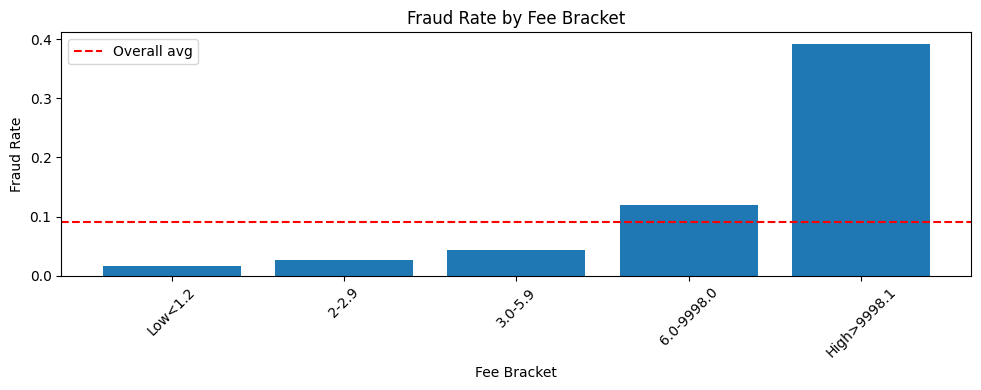

In [ ]:
# ✅ Create fee brackets
master_df['fee_bracket'] = pd.cut(master_df['fee'],
                                   bins=[0, 2, 3, 5, 9, 9999.99],
                                   labels=['Low<1.2', '2-2.9', '3.0-5.9', '6.0-9998.0', 'High>9998.1'])

# ✅ Group by fee_bracket instead of fee
fraud_by_fee = master_df.groupby('fee_bracket')['is_fraud'].mean()
print(fraud_by_fee)

# ✅ Plot with 5 x-axis columns
plt.figure(figsize=(10, 4))
plt.bar(range(len(fraud_by_fee)), fraud_by_fee.values)
plt.xticks(range(len(fraud_by_fee)), fraud_by_fee.index, rotation=45)
plt.xlabel('Fee Bracket')
plt.ylabel('Fraud Rate')
plt.title('Fraud Rate by Fee Bracket')
plt.axhline(y=master_df['is_fraud'].mean(), color='r', linestyle='--', label='Overall avg')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
master_df[master_df['fee'] < 0].shape

(0, 32)

In [ ]:
master_df['fee_bracket'].isna().shape

(10901,)

In [ ]:
# ✅ Create 'fee_bracket' column based on fee value
master_df["fee_bracket"] = master_df["fee"].apply(
    lambda x: "high risk" if x > 9998.99 else "no risk"
)

# ✅ Preview the result
print(master_df[["fee", "fee_bracket"]].head())

    fee fee_bracket
0  4.25     no risk
1  4.24     no risk
2  2.70     no risk
3  2.22     no risk
4  3.61     no risk


#

#

- visualizing the fraudulent rate of higher `ip_risk_score` column

In [ ]:
master_df['ip_risk_score'].describe()

,ip_risk_score
count,10901.000000
mean,0.398357
std,0.271622
min,0.004000
25%,0.209000
50%,0.326000
75%,0.489000
max,1.200000


ip_risk_score_bracket
Low<0.3     0.015558
0.3-0.5     0.022314
0.5-0.7     0.029496
0.7-0.9     0.230233
High>0.9    0.625332
Name: is_fraud, dtype: float64


/tmp/ipython-input-2795810733.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_by_bracket = master_df.groupby('ip_risk_score_bracket')['is_fraud'].mean()


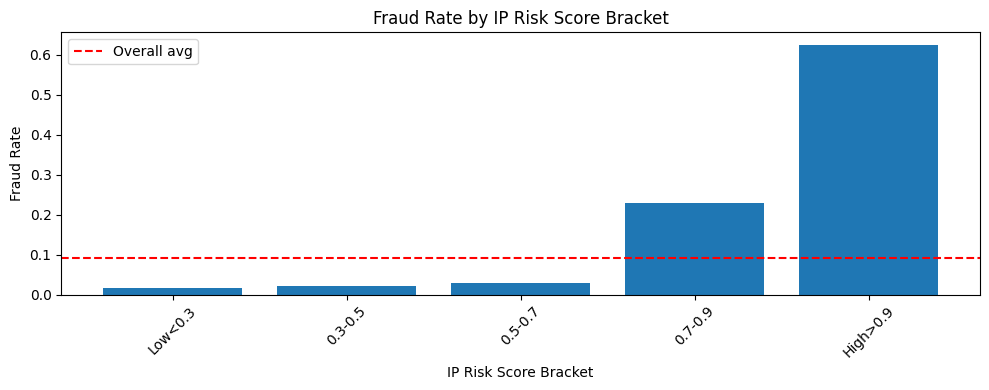

In [ ]:
# ✅ Create 5 brackets for ip_risk_score
master_df['ip_risk_score_bracket'] = pd.cut(
    master_df['ip_risk_score'],
    bins=[0, 0.3, 0.5, 0.7, 0.9, 1.2],
    labels=['Low<0.3', '0.3-0.5', '0.5-0.7', '0.7-0.9', 'High>0.9'],
    include_lowest=True
)

# ✅ Group by the bracket instead of raw score
fraud_by_bracket = master_df.groupby('ip_risk_score_bracket')['is_fraud'].mean()
print(fraud_by_bracket)

# ✅ Plot with 5 bars on the x-axis
plt.figure(figsize=(10, 4))
plt.bar(range(len(fraud_by_bracket)), fraud_by_bracket.values)
plt.xticks(range(len(fraud_by_bracket)), fraud_by_bracket.index, rotation=45)
plt.xlabel('IP Risk Score Bracket')
plt.ylabel('Fraud Rate')
plt.title('Fraud Rate by IP Risk Score Bracket')
plt.axhline(y=master_df['is_fraud'].mean(), color='r', linestyle='--', label='Overall avg')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
master_df['ip_risk_score'].isna().shape

(10901,)

In [ ]:
# ✅ Create 'ip_risk_score_bracket' column based on ip_risk_score value
master_df["ip_risk_score_bracket"] = master_df["ip_risk_score"].apply(
    lambda x: "high risk" if x > 0.9 else "no risk"
)

# ✅ Preview the result
print(master_df[["ip_risk_score", "ip_risk_score_bracket"]].head())

   ip_risk_score ip_risk_score_bracket
0          0.123               no risk
1          0.569               no risk
2          0.437               no risk
3          0.594               no risk
4          0.121               no risk


- visualizing the fraudulent rate of higher `device_trust_score` column

In [ ]:
master_df['device_trust_score'].describe()

,device_trust_score
count,10901.000000
mean,0.653917
std,0.272335
min,-0.100000
25%,0.515000
50%,0.658000
75%,0.894000
max,0.999000


In [ ]:
master_df[master_df['device_trust_score'] < 0].shape

(190, 33)

In [ ]:
master_df[master_df['device_trust_score'] == 0].shape

(0, 33)

In [ ]:
def fix_negative_device_trust_score(df):
    df['device_trust_score'] = df['device_trust_score'].abs()
    return df
master_df = fix_negative_device_trust_score(master_df)

device_trust_bucket
Low<0.3     0.675824
0.3-0.5     0.112812
0.5-0.7     0.020480
0.7-0.9     0.033427
High>0.9    0.008226
Name: is_fraud, dtype: float64


/tmp/ipython-input-2707725552.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_by_device = master_df.groupby('device_trust_bucket')['is_fraud'].mean()


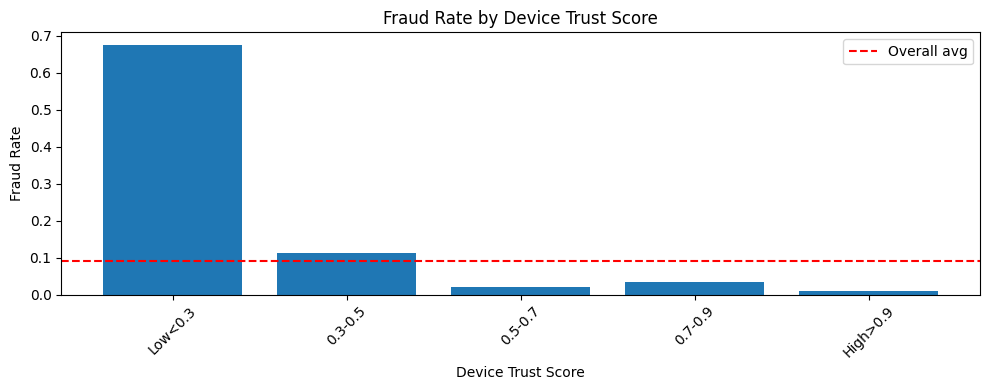

In [ ]:
# Fraud rate by device trust score buckets
master_df['device_trust_bucket'] = pd.cut(master_df['device_trust_score'],
                                   bins=[0, 0.3, 0.5, 0.7, 0.9, 1.0],
                                   labels=['Low<0.3', '0.3-0.5', '0.5-0.7', '0.7-0.9', 'High>0.9'])

fraud_by_device = master_df.groupby('device_trust_bucket')['is_fraud'].mean()
print(fraud_by_device)

plt.figure(figsize=(10, 4))
plt.bar(range(len(fraud_by_device)), fraud_by_device.values)
plt.xticks(range(len(fraud_by_device)), fraud_by_device.index, rotation=45)
plt.xlabel('Device Trust Score')
plt.ylabel('Fraud Rate')
plt.title('Fraud Rate by Device Trust Score')
plt.axhline(y=master_df['is_fraud'].mean(), color='r', linestyle='--', label='Overall avg')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
master_df[master_df['device_trust_score'] < 0].shape

(0, 34)

In [ ]:
master_df['device_trust_score'].isna().shape

(10901,)

In [ ]:
# ✅ Create 'device_trust_bucket' column based on device_trust_score value
master_df["device_trust_bucket"] = master_df["device_trust_score"].apply(
    lambda x: "high risk" if x > 0.9 else "no risk"
)

# ✅ Preview the result
print(master_df[["device_trust_score", "device_trust_bucket"]].head())

   device_trust_score device_trust_bucket
0               0.522             no risk
1               0.475             no risk
2               0.939           high risk
3               0.551             no risk
4               0.894             no risk


#

#

- **Correcting invalid negative values in the trust score**

In [ ]:
# plt.figure(figsize=(6, 4))
# sns.histplot(master_df['device_trust_score'], bins=5, color='teal')
# plt.title('Distribution of Device Trust Score Values')
# plt.xlabel('Device Trust Score')
# plt.ylabel('Frequency')
# plt.show();

In [ ]:
# # calculating the device_trust_score average value (excluding the negative values)
# avg_device_trust_score = master_df[master_df['device_trust_score'] > 0]
# avg_negative_device_trust_score = avg_device_trust_score['device_trust_score'].mean()
# avg_negative_device_trust_score

In [ ]:
# master_df.loc[master_df['device_trust_score'] < 0, 'device_trust_score'] = avg_negative_device_trust_score

In [ ]:
# master_df[master_df['device_trust_score'] < 0]

#

- **Correcting invalid negative fee values**

In [ ]:
# plt.figure(figsize=(6, 4))
# sns.histplot(master_df['fee'], bins=5, color='teal')
# plt.title('Distribution of Fee Values')
# plt.xlabel('Fee Value')
# plt.ylabel('Frequency')
# plt.show();

In [ ]:
# avg_negative_fee = master_df[master_df['device_trust_score'] > 0]
# avg_negative_fee = avg_negative_fee['fee'].mean()
# avg_negative_fee

In [ ]:
# master_df.loc[master_df['fee'] < 0, 'fee'] = avg_negative_fee

In [ ]:
# master_df[master_df['fee'] < 0]

#

- **Handling negative entries in `txn_velocity_1h`**

In [ ]:
# master_df[master_df['txn_velocity_1h'] < 0].nunique().sum()

In [ ]:
# # import numpy as np
# # Replace negatives with 0 for strictly non-negative features
# master_df['txn_velocity_1h'] = master_df['txn_velocity_1h'].clip(lower=0)

 This replaces any negative values in this column with 0. This is important because transaction velocity, which measures the rate of transactions, should logically never be a negative number.

 ---

In [ ]:
# master_df[master_df['txn_velocity_1h'] < 0]

#

In [ ]:
# master_df[master_df['exchange_rate_src_to_dest'] < 0]

#

- **Handling negative entries in the `amount_src` column**

In [ ]:
master_df[master_df['amount_src'] < 0].head(2)

,transaction_id,customer_id,timestamp,home_country,source_currency,dest_currency,channel,amount_src,amount_usd,fee,...,corridor_risk,is_fraud,amount_dest,date_only,time_only,days_only,period_of_the_day,fee_bracket,ip_risk_score_bracket,device_trust_bucket
316,3bcab4c7-dc2e-416c-b57e-266aafe46a47,d71c91b4-fee8-4104-9856-a5c6109a62e3,2022-11-10 03:14:05,US,USD,NGN,MOBILE,-37.08,37.08,9999.99,...,0.25,False,-41199.999996,2022-11-10,1900-01-01 03:14:05,Thursday,Night,high risk,high risk,no risk
539,8e0f5d06-a518-4b0c-ab83-5208837bc5be,af8ca4c4-8703-4c55-b66c-2b76cd70040d,2022-12-07 17:24:01,US,USD,USD,WEB,-176.92,176.92,9999.99,...,0.00,False,-176.920000,2022-12-07,1900-01-01 17:24:01,Wednesday,Evening,high risk,high risk,no risk


#

- **Replacing negative values in selected columns with absolute values**

In [ ]:
import pandas as pd

def fix_negative_amounts(df):
    df['amount_src'] = df['amount_src'].abs()
    return df
master_df = fix_negative_amounts(master_df)

- This function called fix_negative_amounts that takes a pandas DataFrame as input. Its purpose is to replace any negative values in the 'amount_src' column with their positive equivalents by applying the absolute value function (.abs()). The function then returns the modified DataFrame.

---

In [ ]:
master_df[master_df['amount_src'] < 0].head(2)

,transaction_id,customer_id,timestamp,home_country,source_currency,dest_currency,channel,amount_src,amount_usd,fee,...,corridor_risk,is_fraud,amount_dest,date_only,time_only,days_only,period_of_the_day,fee_bracket,ip_risk_score_bracket,device_trust_bucket


In [ ]:
master_df = compute_destination_amount(master_df)
master_df[['source_currency', 'dest_currency', 'amount_src', 'exchange_rate_src_to_dest', 'amount_dest']].head()

,source_currency,dest_currency,amount_src,exchange_rate_src_to_dest,amount_dest
0,USD,CAD,278.19,1.351351,375.932335
1,CAD,MXN,208.51,12.758621,2660.300065
2,USD,CNY,160.33,7.142857,1145.214263
3,USD,EUR,59.41,0.925926,55.009264
4,USD,INR,200.96,83.333333,16746.666600


#

In [ ]:
master_df.describe()

,timestamp,amount_src,amount_usd,fee,exchange_rate_src_to_dest,ip_risk_score,account_age_days,device_trust_score,chargeback_history_count,risk_score_internal,txn_velocity_1h,txn_velocity_24h,corridor_risk,amount_dest,date_only,time_only
count,10901,10901.000000,10901.000000,10901.000000,10901.000000,10901.000000,10901.000000,10901.000000,10901.000000,10901.000000,10901.000000,10901.000000,10901.000000,1.090100e+04,10901,10901
mean,2024-05-03 06:07:00.533299712,446.281127,451.678850,96.559836,167.390533,0.398357,391.963490,0.657403,0.050729,0.268472,0.474452,0.747271,0.045432,8.792956e+04,2024-05-02 18:05:03.164847104,1900-01-01 12:01:57.367122176
min,2022-10-03 18:40:59,7.230000,7.230000,0.500000,0.592000,0.004000,1.000000,0.005000,0.000000,0.000000,-1.000000,0.000000,0.000000,5.784000e+00,2022-10-03 00:00:00,1900-01-01 00:00:01
25%,2023-08-15 04:45:22,92.340000,92.500000,2.380000,1.000000,0.209000,147.000000,0.515000,0.000000,0.169000,0.000000,0.000000,0.000000,1.730371e+02,2023-08-15 00:00:00,1900-01-01 05:59:04
50%,2024-05-09 01:17:38,160.480000,163.480000,3.500000,7.142857,0.326000,272.000000,0.658000,0.000000,0.223000,0.000000,0.000000,0.000000,1.107567e+03,2024-05-09 00:00:00,1900-01-01 12:02:33
75%,2025-01-29 02:41:23,297.760000,302.690000,5.560000,73.529412,0.489000,661.000000,0.894000,0.000000,0.391000,0.000000,0.000000,0.050000,1.312345e+04,2025-01-29 00:00:00,1900-01-01 18:05:20
max,2025-12-16 00:13:41,11942.890000,12498.570000,9999.990000,1388.888889,1.200000,1095.000000,0.999000,2.000000,0.900000,8.000000,11.000000,0.250000,1.388471e+07,2025-12-16 00:00:00,1900-01-01 23:59:59
std,NaN,1379.960293,1400.968088,938.648610,382.078756,0.271622,341.813834,0.263808,0.261777,0.144337,1.546293,1.990867,0.084809,6.070497e+05,NaN,NaN


In [ ]:

master_df[master_df['amount_dest'] < 0]

,transaction_id,customer_id,timestamp,home_country,source_currency,dest_currency,channel,amount_src,amount_usd,fee,...,corridor_risk,is_fraud,amount_dest,date_only,time_only,days_only,period_of_the_day,fee_bracket,ip_risk_score_bracket,device_trust_bucket


In [ ]:
master_df['amount_src'].describe()

,amount_src
count,10901.000000
mean,446.281127
std,1379.960293
min,7.230000
25%,92.340000
50%,160.480000
75%,297.760000
max,11942.890000


In [ ]:
master_df.shape

(10901, 34)

In [401]:
# Find the index of the row with the latest timestamp
latest_index = master_df[master_df['timestamp'] == master_df['timestamp'].max()].index

# Drop that row
master_df.drop(latest_index, inplace=True)

In [402]:
master_df.to_csv('/content/drive/MyDrive/NovaPay_Fraud_Predictive_Model/nova_master_df.csv')

In [403]:
master_df.groupby('is_fraud')['device_trust_bucket'].value_counts()

is_fraud  device_trust_bucket
False     no risk                7381
          high risk              2531
True      no risk                 967
          high risk                21
Name: count, dtype: int64